# 2 A Deeper Insight into DataFrames
[pyspark Doc](https://spark.apache.org/docs/2.4.5/api/python/index.html)

our mission for today is to get a better understandig of `DataFrame` objects, their structure and how to operate with them. Since handling data of different shapes was always a challange in our life as ETL developer so far,  we start with the schema topic, which already came across yesterday.

## Schemas

So far, we've learned two things about schemas in Spark. First, they define the names and types of `DataFrame` `Columns`. However Spark is using internal types of its Catalyst language regardless of the API language we are using. Second,  we can ask Spark to derive the schema from a source file or  we can explicitly define the schema of the data  we want to process.

Spark derives the schema by just reading a small sample of data in the file, which might not be representitive enough for the entire dataset. So maybe for production purposes it might be a better idea to express our expectation explicitly of how the data  we want to process and analyse is actually shaped.

How does schemas look like in Spark? The`printSchema()` function will help me.

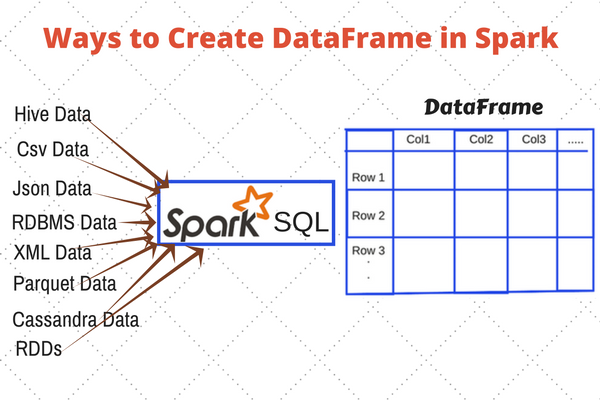

In [134]:
from pyspark_start import *

In [135]:
#python
import pandas as pd
PandasDF=pd.read_csv("./data/flight-data/2015-summary.csv")
PandasDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   DEST_COUNTRY_NAME    256 non-null    object
 1   ORIGIN_COUNTRY_NAME  256 non-null    object
 2   count                256 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 6.1+ KB


In [168]:
PandasDF.describe()

,count
count,256.000000
mean,1770.765625
std,23126.516919
min,1.000000
25%,14.750000
50%,63.500000
75%,270.750000
max,370002.000000


In [138]:
csvData = spark.read\
   .option("header", "true")\
   .option("inferSchema", "true")\
   .format("csv")\
   .load("./data/flight-data/2015-summary.csv")\
#    .printSchema()

In [139]:
csvData.show(1)

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Romania|   15|
+-----------------+-------------------+-----+
only showing top 1 row



In [141]:
jsonData = spark.read\
   .option("inferSchema", "true")\
   .format("json")\
   .load("./data/flight-data/2015-summary.json")\
#    .printSchema()

In [143]:
jsonData.show()

+--------------------+-------------------+-----+
|   DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+--------------------+-------------------+-----+
|       United States|            Romania|   15|
|       United States|            Croatia|    1|
|       United States|            Ireland|  344|
|               Egypt|      United States|   15|
|       United States|              India|   62|
|       United States|          Singapore|    1|
|       United States|            Grenada|   62|
|          Costa Rica|      United States|  588|
|             Senegal|      United States|   40|
|             Moldova|      United States|    1|
|       United States|       Sint Maarten|  325|
|       United States|   Marshall Islands|   39|
|              Guyana|      United States|   64|
|               Malta|      United States|    1|
|            Anguilla|      United States|   41|
|             Bolivia|      United States|   30|
|       United States|           Paraguay|    6|
|             Algeri

In [146]:
jsonData.take(3)
# pd.DataFrame(jsonData.take(3))

[Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Romania', count=15),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Croatia', count=1),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Ireland', count=344)]

Ok, the first thing we notice here is, even though both files have different format, CSV vs. JSON, they have nearly identical schema, i.e. having the same column names and types. The only difference is, that  Spark interprets values in the CSV file as strings and not as `long` numbers.



To find out how to define a schema in Spark, we have look at, how Spark does it.

In [147]:
spark.read\
   .option("header", "true")\
   .format("csv")\
   .load("./data/flight-data/2015-summary.csv")\
   .schema

StructType([StructField('DEST_COUNTRY_NAME', StringType(), True), StructField('ORIGIN_COUNTRY_NAME', StringType(), True), StructField('count', StringType(), True)])

In [148]:
spark.read\
   .format("json")\
   .load("./data/flight-data/2015-summary.json")\
   .schema

StructType([StructField('DEST_COUNTRY_NAME', StringType(), True), StructField('ORIGIN_COUNTRY_NAME', StringType(), True), StructField('count', LongType(), True)])

Now we have the blueprints to create similar schemas by ourselves, e.g. to define the "count" column as optional. One tricky aspect here is, that to define a schema we need to call the constructor methods of the Spark internal types, e.g. `StringType()`, just using the typename like `StringType` won't work.

In [149]:
from pyspark.sql.types import StructField, StructType, StringType, LongType

myOwnCsv = StructType([
    StructField("DEST_COUNTRY_NAME",StringType(),True),
    StructField("ORIGIN_COUNTRY_NAME",StringType(),True),
#     StructField("count",StringType(),False)
    StructField("count",LongType(),False)
])

myOwnJson = StructType([
    StructField("DEST_COUNTRY_NAME",StringType(),True),
    StructField("ORIGIN_COUNTRY_NAME",StringType(),True),
    StructField("count",LongType(),False)
])

Since our schema definitions are less restrictive, the file load should also work when we enforce them explicitly by calling the `schema()` function. 

In [150]:
spDF=spark.read\
   .option("header", "true")\
   .format("csv")\
   .schema(myOwnCsv)\
   .load("./data/flight-data/2015-summary.csv")\
#    .show(5)

In [151]:
spDF.printSchema()

root
 |-- DEST_COUNTRY_NAME: string (nullable = true)
 |-- ORIGIN_COUNTRY_NAME: string (nullable = true)
 |-- count: long (nullable = true)



In [152]:
spark.read\
   .format("json")\
   .schema(myOwnJson)\
   .load("./data/flight-data/2015-summary.json")\
   .show(5)

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Romania|   15|
|    United States|            Croatia|    1|
|    United States|            Ireland|  344|
|            Egypt|      United States|   15|
|    United States|              India|   62|
+-----------------+-------------------+-----+
only showing top 5 rows



And they do.
## Columns and Expressions
The `DataFrame` API provides two ways how to create `Column` objects using either the `col()` or the `expr()` function, which confuses us at first sight. If we apply both of them on the "count" column of our test data, we get exactly the same result.

In [153]:
from pyspark.sql.functions  import col, expr
df = spark.read\
   .option("header", "true")\
   .format("csv")\
   .schema(myOwnCsv)\
   .load("./data/flight-data/2015-summary.csv")

In [154]:
df.select("ORIGIN_COUNTRY_NAME", "count", col("count") -10).show(5)

+-------------------+-----+------------+
|ORIGIN_COUNTRY_NAME|count|(count - 10)|
+-------------------+-----+------------+
|            Romania|   15|           5|
|            Croatia|    1|          -9|
|            Ireland|  344|         334|
|      United States|   15|           5|
|              India|   62|          52|
+-------------------+-----+------------+
only showing top 5 rows



In [156]:
df.createOrReplaceTempView("df_sql")
# df.createOrReplaceTempView("df_sql1")
from pyspark.sql.functions import desc
# transformation
maxSql = spark.sql("""SELECT DEST_COUNTRY_NAME, count,count-10
FROM df_sql limit 5
""")
# action
maxSql.show()

+-----------------+-----+------------+
|DEST_COUNTRY_NAME|count|(count - 10)|
+-----------------+-----+------------+
|    United States|   15|           5|
|    United States|    1|          -9|
|    United States|  344|         334|
|            Egypt|   15|           5|
|    United States|   62|          52|
+-----------------+-----+------------+



In [158]:
df.createOrReplaceTempView("df_sql")
df.createOrReplaceTempView("df_sql1")
# from pyspark.sql.functions import desc
# transformation
maxSql = spark.sql("""SELECT DEST_COUNTRY_NAME, sum(count) as destination_total
FROM df_sql
GROUP BY DEST_COUNTRY_NAME
--ORDER BY sum(count) DESC

union all

SELECT DEST_COUNTRY_NAME, sum(count) as destination_total
FROM df_sql1
GROUP BY DEST_COUNTRY_NAME
ORDER BY destination_total DESC

""")
# action
maxSql.show()

+------------------+-----------------+
| DEST_COUNTRY_NAME|destination_total|
+------------------+-----------------+
|     United States|           411352|
|     United States|           411352|
|            Canada|             8399|
|            Canada|             8399|
|            Mexico|             7140|
|            Mexico|             7140|
|    United Kingdom|             2025|
|    United Kingdom|             2025|
|             Japan|             1548|
|             Japan|             1548|
|           Germany|             1468|
|           Germany|             1468|
|Dominican Republic|             1353|
|Dominican Republic|             1353|
|       South Korea|             1048|
|       South Korea|             1048|
|       The Bahamas|              955|
|       The Bahamas|              955|
|            France|              935|
|            France|              935|
+------------------+-----------------+
only showing top 20 rows



In [159]:
df.select("ORIGIN_COUNTRY_NAME", "count", expr("count - 10")).show(5)

+-------------------+-----+------------+
|ORIGIN_COUNTRY_NAME|count|(count - 10)|
+-------------------+-----+------------+
|            Romania|   15|           5|
|            Croatia|    1|          -9|
|            Ireland|  344|         334|
|      United States|   15|           5|
|              India|   62|          52|
+-------------------+-----+------------+
only showing top 5 rows



Ok Spark, explain to us what's going on behind the scenes.

In [160]:
df.select("ORIGIN_COUNTRY_NAME", "count", col("count") - 10).explain() 

== Physical Plan ==
*(1) Project [ORIGIN_COUNTRY_NAME#2009, count#2010L, (count#2010L - 10) AS (count - 10)#2143L]
+- FileScan csv [ORIGIN_COUNTRY_NAME#2009,count#2010L] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/C:/Business_Data_Analysis/pyspark_class/data/flight-data/2015-su..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<ORIGIN_COUNTRY_NAME:string,count:bigint>




In [161]:
df.select("ORIGIN_COUNTRY_NAME", "count", expr("count - 10")).explain()

== Physical Plan ==
*(1) Project [ORIGIN_COUNTRY_NAME#2009, count#2010L, (count#2010L - 10) AS (count - 10)#2147L]
+- FileScan csv [ORIGIN_COUNTRY_NAME#2009,count#2010L] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/C:/Business_Data_Analysis/pyspark_class/data/flight-data/2015-su..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<ORIGIN_COUNTRY_NAME:string,count:bigint>




In [162]:
df.selectExpr("ORIGIN_COUNTRY_NAME", "count", "count - 10").explain()

== Physical Plan ==
*(1) Project [ORIGIN_COUNTRY_NAME#2009, count#2010L, (count#2010L - 10) AS (count - 10)#2151L]
+- FileScan csv [ORIGIN_COUNTRY_NAME#2009,count#2010L] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/C:/Business_Data_Analysis/pyspark_class/data/flight-data/2015-su..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<ORIGIN_COUNTRY_NAME:string,count:bigint>




In [163]:
df.createOrReplaceTempView("table")
spark.sql("""SELECT ORIGIN_COUNTRY_NAME, count, count -10 FROM table""").explain()

== Physical Plan ==
*(1) Project [ORIGIN_COUNTRY_NAME#2009, count#2010L, (count#2010L - 10) AS (count - 10)#2155L]
+- FileScan csv [ORIGIN_COUNTRY_NAME#2009,count#2010L] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/C:/Business_Data_Analysis/pyspark_class/data/flight-data/2015-su..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<ORIGIN_COUNTRY_NAME:string,count:bigint>




As we've learned on day 2, any functional transformation on `DataFrame` objects is equivalent to SQL queries on tables, so `col("columnName")` is equivalent to the projection in relational algebra in terms of, take the third data element of each record (row). So finally there are three equivalent ways how to express transformations in Spark:
* as a composition of funtion: `select(col("count") - 10)`
* as an expression String: `select(expr("count - 10")* or *selectExpr("count - 10"))`
* as SQL query: `sql("""SELECT count - 10 FROM""")`

## DataFrame Metadata
`DataFrame` objects have attributes describing their metadata. The attribute `column` provides a list of all column names of the given `DataFrame`. Python lists are iterable objects so we can use this attribute to iterate over all column names of a `DataFrame`.

In [164]:
df.columns

['DEST_COUNTRY_NAME', 'ORIGIN_COUNTRY_NAME', 'count']

If we need the data types as well, we can use the attribute `dtypes` instead.

In [165]:
df.dtypes

[('DEST_COUNTRY_NAME', 'string'),
 ('ORIGIN_COUNTRY_NAME', 'string'),
 ('count', 'bigint')]

The number of rows in the `DataFrame`.

In [166]:
df.count()

256

Some basic statistics about the column values are also available for data profiling

In [167]:
df.describe().show()

+-------+-----------------+-------------------+------------------+
|summary|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|             count|
+-------+-----------------+-------------------+------------------+
|  count|              256|                256|               256|
|   mean|             null|               null|       1770.765625|
| stddev|             null|               null|23126.516918551915|
|    min|          Algeria|             Angola|                 1|
|    max|           Zambia|            Vietnam|            370002|
+-------+-----------------+-------------------+------------------+



In [74]:
df.summary().show()

+-------+-----------------+-------------------+------------------+
|summary|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|             count|
+-------+-----------------+-------------------+------------------+
|  count|              256|                256|               256|
|   mean|             null|               null|       1770.765625|
| stddev|             null|               null|23126.516918551915|
|    min|          Algeria|             Angola|                 1|
|    25%|             null|               null|                14|
|    50%|             null|               null|                63|
|    75%|             null|               null|               268|
|    max|           Zambia|            Vietnam|            370002|
+-------+-----------------+-------------------+------------------+



## Records and Rows

Records are logical sets of related data values. In Spark they are technically represented by `Row` objects.

Spark `DataFrame` objects are collections of `Row` objects all having the same structure according to the schema of the `DataFrame`. we can create a `Row` object by ourselves, even independently from any schema or the existens of a `DataFrame`, which is not possible for `Column` objects.  

In [169]:
from pyspark.sql import Row
myOwnRow = Row(42, "is the answer to all questions", True)
type(myOwnRow)

pyspark.sql.types.Row

There is now `DataFrame` so no schema yet, but we have a row now. Like with Python lists we can access the `Row` data elements by their positional index starting with 0 for the first element.

In [170]:
myOwnRow[1]

'is the answer to all questions'

Well, the schema comes back into place as soon as we want to collect multiple records into the same `DataFrame` because than, all records must comply with the same schema.

Next to creating DataFrames on the fly from source files, like we did so far, we could also create our `DataFrame` by our own. This get's relevant to me, when there is no data source because we created the data by ourselves, e.g. simulated scenario data. All we need to is creating a schema, like we did on day 2 an some `Row` objects like we created just before and compile both into a `DataFrame`.

In [171]:
from pyspark.sql.types import LongType, StringType, BooleanType

myOwnSchema = StructType([
    StructField("ID", LongType(), True),
    StructField("Message", StringType(), True),
    StructField("is true or false", BooleanType(), True),
])

In [172]:
mySecondRow = Row(73, "is a prime number", True)

In [173]:
myDF = spark.createDataFrame([myOwnRow, mySecondRow], myOwnSchema)
myDF.show()

+---+--------------------+----------------+
| ID|             Message|is true or false|
+---+--------------------+----------------+
| 42|is the answer to ...|            true|
| 73|   is a prime number|            true|
+---+--------------------+----------------+



The `DataFrame` custructor `createDataFrame()` accepts a list of `Row` objects, so we don't have to insert rows manually one-by-one but can handover a list objects which we've maybe generated at another place in our code.

> **Note:** 
> By default, `show()` truncates strings longer than 20 characters.  setting this paramter to FALS or we can 
> define another number of character limit

In [174]:
rowList = [myOwnRow, mySecondRow]
myDF = spark.createDataFrame(rowList, myOwnSchema)
myDF.show(truncate=False)

+---+------------------------------+----------------+
|ID |Message                       |is true or false|
+---+------------------------------+----------------+
|42 |is the answer to all questions|true            |
|73 |is a prime number             |true            |
+---+------------------------------+----------------+



In [83]:
myDF.show(truncate=25)

+---+-------------------------+----------------+
| ID|                  Message|is true or false|
+---+-------------------------+----------------+
| 42|is the answer to all q...|            true|
| 73|        is a prime number|            true|
+---+-------------------------+----------------+



## DataFrame Transformations
Eventhough rows are individual objects, Spark does not manipulate them individually. To keep mass data processing fast, `Row` objects are manipulated by column expressions applied on `DataFrame`, which in fact are collections of `Row` objects. Again this is equivalent to the relational algebra of SQL SELECT queries. Here are some common example, we are familiar with in SQL, but how do they look like in the functional format?
### Adding a Column with Literal Values

In [175]:
from pyspark.sql.functions import lit

myDF\
   .select(col("ID"), col("Message"))\
   .withColumn("literal", lit(23))\
   .show(truncate=False)

+---+------------------------------+-------+
|ID |Message                       |literal|
+---+------------------------------+-------+
|42 |is the answer to all questions|23     |
|73 |is a prime number             |23     |
+---+------------------------------+-------+



In [86]:
from pyspark.sql.functions import lit

myDF\
   .select("ID", "Message",lit(23))\
   .show(truncate=False)

+---+------------------------------+---+
|ID |Message                       |23 |
+---+------------------------------+---+
|42 |is the answer to all questions|23 |
|73 |is a prime number             |23 |
+---+------------------------------+---+



Alternatively, we could use `alias()` instead and create the new column inside of `select()`.

In [87]:
myDF\
   .select(col("ID"), col("Message"), lit(23).alias("literal"))\
   .show(truncate=False)

+---+------------------------------+-------+
|ID |Message                       |literal|
+---+------------------------------+-------+
|42 |is the answer to all questions|23     |
|73 |is a prime number             |23     |
+---+------------------------------+-------+



we appreaciate the readability when using `withColumn()`, especually in more complex queries. On the other hand it is less flexible because new columns get always appended to the right whereas with the second approach, using `alias()`, we can put the new `Column` at any position in the `DataFrame`.

In [30]:
myDF\
   .select(col("ID"), lit(23).alias("literal"), col("Message"))\
   .show(truncate=False)

+---+-------+------------------------------+
|ID |literal|Message                       |
+---+-------+------------------------------+
|42 |23     |is the answer to all questions|
|73 |23     |is a prime number             |
+---+-------+------------------------------+



In [176]:
myDF.createOrReplaceTempView("df_sql2")
# from pyspark.sql.functions import desc
# transformation
maxSql = spark.sql("""
select ID, 23 AS LITERAL, Message from df_sql2

""")
# action
maxSql.show(truncate=False)

+---+-------+------------------------------+
|ID |LITERAL|Message                       |
+---+-------+------------------------------+
|42 |23     |is the answer to all questions|
|73 |23     |is a prime number             |
+---+-------+------------------------------+



### Adding a Calculated Column

In [31]:
myDF\
   .select(col("ID"), col("Message"))\
   .withColumn("Calculated ID", col("ID") * 100)\
   .show(truncate=False)

+---+------------------------------+-------------+
|ID |Message                       |Calculated ID|
+---+------------------------------+-------------+
|42 |is the answer to all questions|4200         |
|73 |is a prime number             |7300         |
+---+------------------------------+-------------+



In [32]:
myDF\
   .select(col("ID"), col("Message"), (col("ID") * 100).alias("ID calculated"))\
   .show(truncate=False)

+---+------------------------------+-------------+
|ID |Message                       |ID calculated|
+---+------------------------------+-------------+
|42 |is the answer to all questions|4200         |
|73 |is a prime number             |7300         |
+---+------------------------------+-------------+



In both versions the new Column "ID Calculated" is the result of three consecutive expressions
* `col("ID")`, i.e. take first data element of each row in the input DataFrame
* `* 100`, i.e. multiply each data value by 100
* `alias("ID calculated")` to rename the new column

The first two are data manipulating whereas the third one manipulates the metadata of the `DataFrame`

### Renaming Columns

In [33]:
myDF\
   .select(col("ID"), col("Message"))\
   .withColumnRenamed("ID", "Identifier")\
   .show(truncate=False)

+----------+------------------------------+
|Identifier|Message                       |
+----------+------------------------------+
|42        |is the answer to all questions|
|73        |is a prime number             |
+----------+------------------------------+



In [34]:
myDF\
   .select(col("ID").alias("Identifier"), col("Message"))\
   .show(truncate=False)

+----------+------------------------------+
|Identifier|Message                       |
+----------+------------------------------+
|42        |is the answer to all questions|
|73        |is a prime number             |
+----------+------------------------------+



In [115]:
# myDF.createOrReplaceTempView("df_sql2")
# from pyspark.sql.functions import desc
# transformation
maxSql = spark.sql("""
select ID as Identifier,  Message from df_sql2
""")
# action
maxSql.show(truncate=False)

+----------+------------------------------+
|Identifier|Message                       |
+----------+------------------------------+
|42        |is the answer to all questions|
|73        |is a prime number             |
+----------+------------------------------+



In [121]:
# myDF.createOrReplaceTempView("df_sql2")
# from pyspark.sql.functions import desc
# transformation
maxSql = spark.sql("""
select count(*) from df_sql2
""")
# action
maxSql.show(truncate=False)

+--------+
|count(1)|
+--------+
|2       |
+--------+



In our opinion, the Spark syntax regarding column names is quite misleading. Even though we have to put the column name argument in quotation marks and eventhough the output shows us the column name with exactly the same upper/lower cases, as we defined it, Spark is **NOT** case sensitive. 

In [35]:
myDF\
   .select(col("Message"), col("MESSAGE"))\
   .show(truncate=False)

+------------------------------+------------------------------+
|Message                       |MESSAGE                       |
+------------------------------+------------------------------+
|is the answer to all questions|is the answer to all questions|
|is a prime number             |is a prime number             |
+------------------------------+------------------------------+



However, we can switch to case sensitivity by changing the `SparkSession` configuration.

In [98]:
# spark.conf.set("spark.sql.caseSensitive", "true")
spark.conf.set("spark.sql.caseSensitive", "false")

In [97]:
myDF\
   .select(col("ID"), (col("ID") * 100).alias("id"))\
   .select(col("ID"))\
   .show()

+---+
| ID|
+---+
| 42|
| 73|
+---+



Column names with reserved character or keywords can also be very tricky because, as we've seen befor, Spark does not interprete everything in quation marks literally as strings.

In [99]:
dfWithSpecialNames = myDF\
   .select(col("ID"), col("Message"))\
   .withColumn("ID * by 100", col("ID") * 100)

dfWithSpecialNames.show(truncate=False)

+---+------------------------------+-----------+
|ID |Message                       |ID * by 100|
+---+------------------------------+-----------+
|42 |is the answer to all questions|4200       |
|73 |is a prime number             |7300       |
+---+------------------------------+-----------+



The question is, how can we reference the third column without getting problems. First of all the direct string to column reference by using `col()` works fine.

In [100]:
dfWithSpecialNames\
   .select(col("ID * by 100"))\
   .show()

+-----------+
|ID * by 100|
+-----------+
|       4200|
|       7300|
+-----------+



In [101]:
dfWithSpecialNames\
   .select(col("ID * by 100") * 100)\
   .show()

+-------------------+
|(ID * by 100 * 100)|
+-------------------+
|             420000|
|             730000|
+-------------------+



Does this reference also work in expression strings?

In [102]:
dfWithSpecialNames\
   .selectExpr("ID * by 100  * 100")\
   .show()

ParseException: 
Syntax error at or near '100'(line 1, pos 8)

== SQL ==
ID * by 100  * 100
--------^^^


Ups, something got broken. Now it is undefined, which parts of the expression string are operators and which are literal stings valus.  This problem will get very relevant when it comes to filter or join conditions, so we need a solution. Spark provides the back stick character to escape the column name strings.

In [103]:
dfWithSpecialNames\
   .selectExpr("`ID * by 100`  * 100")\
   .show()

+-------------------+
|(ID * by 100 * 100)|
+-------------------+
|             420000|
|             730000|
+-------------------+



Well, our lessons learned her is: avoid blanks, reserved characters or keywords in column names whenever possible.
### Removing Columns
In the SQL world, there is a shortcut to grep all columns using the wildcard, which is very comfortable querying a table with, e.g. 100 columns. What we are realy missing, is the option to exclude just one or two columns and get the remaining 98 columns without having to list them all in the SELECT clause. So we are very happy to see that Spark provides us this feature by the `drop()` function.

In [177]:
dfWithSpecialNames.drop("ID * by 100").show(truncate=False)

+---+------------------------------+
|ID |Message                       |
+---+------------------------------+
|42 |is the answer to all questions|
|73 |is a prime number             |
+---+------------------------------+



### Filtering Rows
Spark provides in total four ways of filtering rows. First, the two methonds `filter()` and `where()` are synonyms in pyspark. Second, the filter condition can either be a boolean column created by column manipualtion or an expression string, which evaluates to True or False.

In [104]:
dfWithSpecialNames.filter(col("ID") == 42).show(truncate=False)

+---+------------------------------+-----------+
|ID |Message                       |ID * by 100|
+---+------------------------------+-----------+
|42 |is the answer to all questions|4200       |
+---+------------------------------+-----------+



In [105]:
dfWithSpecialNames.filter("ID = 42").show(truncate=False)

+---+------------------------------+-----------+
|ID |Message                       |ID * by 100|
+---+------------------------------+-----------+
|42 |is the answer to all questions|4200       |
+---+------------------------------+-----------+



In [106]:
dfWithSpecialNames.where(col("ID") == 42).show(truncate=False)

+---+------------------------------+-----------+
|ID |Message                       |ID * by 100|
+---+------------------------------+-----------+
|42 |is the answer to all questions|4200       |
+---+------------------------------+-----------+



In [107]:
dfWithSpecialNames.where("ID == 42").show(truncate=False)

+---+------------------------------+-----------+
|ID |Message                       |ID * by 100|
+---+------------------------------+-----------+
|42 |is the answer to all questions|4200       |
+---+------------------------------+-----------+



In [109]:
dfWithSpecialNames\
.select("ID","Message")\
.where("ID == 42").show(truncate=False)

+---+------------------------------+
|ID |Message                       |
+---+------------------------------+
|42 |is the answer to all questions|
+---+------------------------------+



The last version looks most familiar to us as an senior SQL user. A nice feature is, that we can chain up multiple AND filters, which is more readable than complex in-line expression.

In [110]:
dfWithSpecialNames\
    .where("ID == 42")\
    .where("`ID * by 100`== 4200")\
    .show(truncate=False)

+---+------------------------------+-----------+
|ID |Message                       |ID * by 100|
+---+------------------------------+-----------+
|42 |is the answer to all questions|4200       |
+---+------------------------------+-----------+



In [111]:
dfWithSpecialNames\
    .where("ID == 42 and `ID * by 100`== 4200")\
    .show(truncate=False)

+---+------------------------------+-----------+
|ID |Message                       |ID * by 100|
+---+------------------------------+-----------+
|42 |is the answer to all questions|4200       |
+---+------------------------------+-----------+



Nevertheless, ass soon as OR comes into place, there is no choice anymore.

In [112]:
dfWithSpecialNames\
    .where("ID == 42 or ID == 73")\
    .show(truncate=False)

+---+------------------------------+-----------+
|ID |Message                       |ID * by 100|
+---+------------------------------+-----------+
|42 |is the answer to all questions|4200       |
|73 |is a prime number             |7300       |
+---+------------------------------+-----------+



Filter expressions can get quite complex and hard to read. Maybe we want to reuse them multiple times in our code and re-writing them all the times makes us pain. Fortunately we have the option to pre-define filter expressions and giving them more self-explaining names, from business point of view. Doing so we can reference these filters by their names in our queries, making them much more readable and the filter expressions reusable.

So our question as a Sales Manager could be: which invoices from the Scandinavian market contain high volumn orders?

In [116]:
from pyspark.sql.functions import col, instr

# loading data from CSV source
dfRetail = spark.read\
    .format("csv")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .load("./data/retail-data/by-day/*.csv")

# named filter expressions evaluating to Boolean
highVolumeOrder = (col("Quantity") >= 40) & (col("UnitPrice") >= 1.50)
Scandinavia = (col("Country") == "Norway") \
               | (col("Country") == "Sweden") \
               | (col("Country") == "Denmark") \
               | (col("Country") == "Finland")

# the query answering our question
dfRetail.where(highVolumeOrder & Scandinavia)\
    .select("InvoiceNo", "Country")\
    .distinct()\
    .show(10)

+---------+-------+
|InvoiceNo|Country|
+---------+-------+
|   580704| Sweden|
|   536532| Norway|
|   576083| Sweden|
|   579881|Denmark|
|   579692| Norway|
|   578300|Finland|
|   567526|Denmark|
|   578089| Sweden|
|   574442|Finland|
|   574332|Finland|
+---------+-------+
only showing top 10 rows



### Random Samples and Split

In [178]:
# import pyspark
import random

# from pyspark.sql import SparkSession
# spark = SparkSession\
#    .builder\
#    .getOrCreate()

df = spark.read\
   .format("csv")\
   .option("header", "true")\
   .option("inferSchema", "true")\
   .load("./data/retail-data/by-day/*.csv")

df.count()

541909

In [179]:
seed = random.seed()
withReplacement = False
fraction = 0.1 # i.e. 10%

In [180]:
df.sample(withReplacement, fraction, seed).count()

54433

In [132]:
help(df.sample)

Help on method sample in module pyspark.sql.dataframe:

sample(withReplacement: Union[float, bool, NoneType] = None, fraction: Union[int, float, NoneType] = None, seed: Optional[int] = None) -> 'DataFrame' method of pyspark.sql.dataframe.DataFrame instance
    Returns a sampled subset of this :class:`DataFrame`.
    
    .. versionadded:: 1.3.0
    
    Parameters
    ----------
    withReplacement : bool, optional
        Sample with replacement or not (default ``False``).
    fraction : float, optional
        Fraction of rows to generate, range [0.0, 1.0].
    seed : int, optional
        Seed for sampling (default a random seed).
    
    Notes
    -----
    This is not guaranteed to provide exactly the fraction specified of the total
    count of the given :class:`DataFrame`.
    
    `fraction` is required and, `withReplacement` and `seed` are optional.
    
    Examples
    --------
    >>> df = spark.range(10)
    >>> df.sample(0.5, 3).count()
    7
    >>> df.sample(fraction=0

In [181]:
df.sample(withReplacement, fraction, seed).show(5)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   580539|    22076|  6 RIBBONS EMPIRE  |      24|2011-12-05 08:39:00|     0.39|   18180.0|United Kingdom|
|   580540|    23556|LANDMARK FRAME CO...|       3|2011-12-05 08:49:00|     12.5|   13417.0|United Kingdom|
|   580540|    22457|NATURAL SLATE HEA...|       6|2011-12-05 08:49:00|     2.95|   13417.0|United Kingdom|
|   580541|    22026|BANQUET BIRTHDAY ...|      12|2011-12-05 09:03:00|     0.42|   15358.0|United Kingdom|
|   580541|    22467|   GUMBALL COAT RACK|       6|2011-12-05 09:03:00|     2.55|   15358.0|United Kingdom|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
only showing top 5 rows



Spark's `ramdomSplit()` feature can be very usefull if we want to train a neural network model where spliting up a dataset by random into two samples, the training data and the test data, is an important datap reparation step. 

In [123]:
seed = random.seed()
mlData = df.randomSplit([0.8, 0.2], seed)
traingData = mlData[0]
testData = mlData[1]

### Other DataFrame Transformations
The following functions are nearly the same as we already know from SQL. So we skip them here.

* `df1.count()`
* `df1.distinct().count()`
* `df1.union(df2)`
* `df1.orderBy(... desc, ... asc)`

### Repartitioning Data
As we've learnd on day 2, wide transformations, forces Spark to shuffel data across the cluster which can end up in performance issues since Spark cannot do it in-memory. Therefore we can improve the performance, if we partition the data according to our expected query patterns. 

Ok, let's see how Spark has partitioned our data, we've read from the daily retail csv files.

In [124]:
df.rdd.getNumPartitions()

10

Currently there are 12 partitions. we want to optimaize the partitioning for queries on stock codes. How many Stock codes do we have?

In [125]:
df.select("StockCode").distinct().count()

4070

One option would be, to raise the number of partitions. But this doesn't help if we have not enough CPU cores.

In [ ]:
# df.repartition(100)

Furthermore, just raising the number of partitions would not ensure, that all rows having the same StockCode value which reside in the same partition. The later is the crucial point to gain partition locality of the query processing. So we have to define the StockCode column as partition criteria.

In [ ]:
df.repartition("StockCode")

Nevertheless, If we had some further CPU cores at hand, can raise the number of partitions additionally.

In [ ]:
df.repartition(20, "StockCode")

### Collecting Rows to Local Driver
Especially when we do some ad-hoc analysis of the data on our local machine, it is quite usefull to limit the data I' fetching from the cluster.

`collect()` returns all the records as a list of `Row` objects. In Python, lists are iterable sequences.

In [126]:
df.collect()

[Row(InvoiceNo='580538', StockCode='23084', Description='RABBIT NIGHT LIGHT', Quantity=48, InvoiceDate=datetime.datetime(2011, 12, 5, 8, 38), UnitPrice=1.79, CustomerID=14075.0, Country='United Kingdom'),
 Row(InvoiceNo='580538', StockCode='23077', Description='DOUGHNUT LIP GLOSS ', Quantity=20, InvoiceDate=datetime.datetime(2011, 12, 5, 8, 38), UnitPrice=1.25, CustomerID=14075.0, Country='United Kingdom'),
 Row(InvoiceNo='580538', StockCode='22906', Description='12 MESSAGE CARDS WITH ENVELOPES', Quantity=24, InvoiceDate=datetime.datetime(2011, 12, 5, 8, 38), UnitPrice=1.65, CustomerID=14075.0, Country='United Kingdom'),
 Row(InvoiceNo='580538', StockCode='21914', Description='BLUE HARMONICA IN BOX ', Quantity=24, InvoiceDate=datetime.datetime(2011, 12, 5, 8, 38), UnitPrice=1.25, CustomerID=14075.0, Country='United Kingdom'),
 Row(InvoiceNo='580538', StockCode='22467', Description='GUMBALL COAT RACK', Quantity=6, InvoiceDate=datetime.datetime(2011, 12, 5, 8, 38), UnitPrice=2.55, Custom

In [127]:
type(df.collect())

list

`limit(num)` limits the result count to the specified number of rows

In [183]:
df.limit(1000).collect()

[Row(InvoiceNo='580538', StockCode='23084', Description='RABBIT NIGHT LIGHT', Quantity=48, InvoiceDate=datetime.datetime(2011, 12, 5, 8, 38), UnitPrice=1.79, CustomerID=14075.0, Country='United Kingdom'),
 Row(InvoiceNo='580538', StockCode='23077', Description='DOUGHNUT LIP GLOSS ', Quantity=20, InvoiceDate=datetime.datetime(2011, 12, 5, 8, 38), UnitPrice=1.25, CustomerID=14075.0, Country='United Kingdom'),
 Row(InvoiceNo='580538', StockCode='22906', Description='12 MESSAGE CARDS WITH ENVELOPES', Quantity=24, InvoiceDate=datetime.datetime(2011, 12, 5, 8, 38), UnitPrice=1.65, CustomerID=14075.0, Country='United Kingdom'),
 Row(InvoiceNo='580538', StockCode='21914', Description='BLUE HARMONICA IN BOX ', Quantity=24, InvoiceDate=datetime.datetime(2011, 12, 5, 8, 38), UnitPrice=1.25, CustomerID=14075.0, Country='United Kingdom'),
 Row(InvoiceNo='580538', StockCode='22467', Description='GUMBALL COAT RACK', Quantity=6, InvoiceDate=datetime.datetime(2011, 12, 5, 8, 38), UnitPrice=2.55, Custom

`take(num)` returns just the first *num* rows as a list of Row objects

In [131]:
df.take(3)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   580538|    23084|  RABBIT NIGHT LIGHT|      48|2011-12-05 08:38:00|     1.79|   14075.0|United Kingdom|
|   580538|    23077| DOUGHNUT LIP GLOSS |      20|2011-12-05 08:38:00|     1.25|   14075.0|United Kingdom|
|   580538|    22906|12 MESSAGE CARDS ...|      24|2011-12-05 08:38:00|     1.65|   14075.0|United Kingdom|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
only showing top 3 rows



AttributeError: 'NoneType' object has no attribute 'toDF'

In [ ]:
type(df.take(3))

If we just want the first row on top, we can do it this way.

In [128]:
df.first()

Row(InvoiceNo='580538', StockCode='23084', Description='RABBIT NIGHT LIGHT', Quantity=48, InvoiceDate=datetime.datetime(2011, 12, 5, 8, 38), UnitPrice=1.79, CustomerID=14075.0, Country='United Kingdom')

`toLocalIterator()` returns an iterator that contains all of the rows in this `DataFrame`. The iterator will consume as much memory as the largest partition in this `DataFrame`.

That's enough for today.